# LDA

In [1]:
import os
import re
import collections
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for pos tagging and lemmatization
import spacy
import nl_core_news_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Process bar
from tqdm import tqdm

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

os.environ['MALLET_HOME'] = 'C:/mallet/mallet-2.0.8'

In [2]:
data = pd.read_csv('2013-2018.csv', error_bad_lines=False);
data = data.loc[data['Taal'] == 'nl']
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27617 entries, 0 to 32481
Data columns (total 9 columns):
Unnamed: 0        27617 non-null int64
Brin              27617 non-null object
Croho             27617 non-null object
CrohoNo           10437 non-null float64
Jaar              27617 non-null int64
OpleidingsVorm    23728 non-null object
Opmerking         27617 non-null object
Taal              27617 non-null object
Degree            27617 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [3]:
data_text = data[['Opmerking']]
data_text['index'] = data_text.index
documents = data_text

C:\Users\Tobias\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
print(len(documents))
print(documents[:5])

27617
                                           Opmerking  index
0  het lesrooster was de vorige perioden veel bet...      0
1  maak een duidelijkere link tussen de stage en ...      1
2  door de te grote opdrachten en de grote reisti...      2
3  de gekozen modules zijn niet voor iedereen eve...      3
4  sneller reageren op vragen die naar examencomm...      4


In [5]:
randomseed = 100

## Preprocessing

### Removing punctuation and converting to lowercase
We start by removing all punctuation and converting everything to lowercase

In [6]:
# Removing punctuation
#documents['Opmerking_processed'] = documents['Opmerking'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
#documents['Opmerking_processed'] = documents['Opmerking_processed'].map(lambda x: x.lower())

documents['Opmerking'].head()

0    het lesrooster was de vorige perioden veel bet...
1    maak een duidelijkere link tussen de stage en ...
2    door de te grote opdrachten en de grote reisti...
3    de gekozen modules zijn niet voor iedereen eve...
4    sneller reageren op vragen die naar examencomm...
Name: Opmerking, dtype: object

### Removing stopwords

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('dutch'))
stop_words.extend(stopwords.words('german'))

# Use the function below to extend the amount of stopwords
# stop_words.extend(['1', '2'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word 
             not in stop_words] for doc in texts]

# Remove Stop Words
data_words = remove_stopwords(documents['Opmerking'])

In [8]:
data_words[:1]

[['lesrooster',
  'vorige',
  'perioden',
  'beter',
  'hadden',
  'elke',
  'week',
  'wel',
  'dag',
  'vrij',
  'waardoor',
  'goed',
  'studie',
  'werken',
  'uur',
  'hoeft',
  'laat',
  'thuis',
  'ivm',
  'reizen']]

### Building Bigrams and Trigrams
We use the individual words to build bigrams and trigrams which are combinations of two or three words that are often used together.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
# Initialize spacy 'nl', 'en', or 'de' model, keeping only tagger component (for efficiency), for now only nl is used
nlp = nl_core_news_sm.load()
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['lesrooster', 'vorig', 'periode', 'goed', 'hebben', 'week', 'wel', 'dag', 'vrij', 'waardoor', 'goed', 'studie', 'werken', 'uur', 'hoeven', 'laten', 'thuis', 'reizen']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


### Building LDA Model

In [13]:
# Build LDA model


lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=randomseed,
                                       chunksize=100,
                                       update_every=1,
                                       passes=10,
                                       per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.105*"toets" + 0.045*"halen" + 0.027*"onduidelijk" + 0.025*"betreffen" + '
  '0.024*"af" + 0.022*"portal" + 0.022*"aangeven" + 0.021*"moeten" + '
  '0.021*"hebben" + 0.020*"blijven"'),
 (1,
  '0.077*"jaar" + 0.062*"stage" + 0.041*"informatie" + 0.029*"duidelijk" + '
  '0.026*"goed" + 0.025*"minor" + 0.021*"volgen" + 0.020*"student" + '
  '0.020*"manier" + 0.019*"lang"'),
 (2,
  '0.073*"periode" + 0.072*"week" + 0.059*"dag" + 0.055*"uur" + '
  '0.054*"project" + 0.034*"vak" + 0.028*"studielast" + 0.028*"goed" + '
  '0.026*"begin" + 0.020*"richten"'),
 (3,
  '0.027*"werken" + 0.025*"groep" + 0.023*"aantal" + 0.020*"college" + '
  '0.019*"goed" + 0.018*"namelijk" + 0.017*"zitten" + 0.016*"ipv" + '
  '0.016*"kwaliteit" + 0.016*"inhoud"'),
 (4,
  '0.045*"begeleiding" + 0.039*"vraag" + 0.030*"werk" + 0.025*"laat" + '
  '0.025*"student" + 0.025*"tijd" + 0.023*"jaar" + 0.022*"opdracht" + '
  '0.021*"staan" + 0.021*"groot"'),
 (5,
  '0.040*"duidelijkheid" + 0.038*"extra" + 0.032*"lasti

Coherence score dropped after applying lemmatization

In [15]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.


# Compute Coherence Score higher is better
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.249892402030163

Coherence Score:  0.4358425032774841


### Visualize the topics-keywords

Each bubble on the plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.221024  0.144591       1        1  24.024845
9      0.202422 -0.040051       2        1  14.944360
6      0.131214 -0.076788       3        1  11.890788
1      0.134244 -0.128611       4        1  11.132853
3     -0.006792  0.275801       5        1   8.836376
4      0.082227 -0.145891       6        1   8.741987
2     -0.113361  0.174342       7        1   6.121701
0     -0.168549 -0.084477       8        1   5.358484
5     -0.270911  0.038197       9        1   5.095168
7     -0.211517 -0.157114      10        1   3.853440, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
63    Default  7233.000000         docent  7233.000000  30.0000  30.0000
106   Default  4721.000000           jaar  4721.000000  29.0000  29.0000
152   Default  2513.000000          toets  2513.000000  28.0000  28.0000
24    Default  3737.000000          stage  3737.000000  27.0000  27.0000
6     Default  1992.000000        periode  1992.000000  26.0000  26.0000
14    Default  1980.000000           week  1980.000000  25.0000  25.0000
49    Default  4807.000000         vinden  4807.000000  24.0000  24.0000
138   Default  9036.000000        student  9036.000000  23.0000  23.0000
25    Default  3733.000000            vak  3733.000000  22.0000  22.0000
0     Default  1623.000000            dag  1623.000000  21.0000  21.0000
173   Default  2065.000000     informatie  2065.000000  20.0000  20.0000
33    Default  2622.000000           tijd  2622.000000  19.0000  19.0000
303   Default  1767.000000    begeleiding  1767.000000  18.0000  18.0000
10    Default  1514.000000            uur  1514.000000  17.0000  17.0000
736   Default  1468.000000        project  1468.000000  16.0000  16.0000
65    Default  4137.000000          geven  4137.000000  15.0000  15.0000
1     Default  9964.000000           goed  9964.000000  14.0000  14.0000
46    Default  6468.000000      opleiding  6468.000000  13.0000  13.0000
174   Default  1772.000000        rooster  1772.000000  12.0000  12.0000
59    Default  1545.000000          vraag  1545.000000  11.0000  11.0000
339   Default  3495.000000           gaan  3495.000000  10.0000  10.0000
17    Default  2248.000000      duidelijk  2248.000000   9.0000   9.0000
160   Default  3874.000000         moeten  3874.000000   8.0000   8.0000
249   Default  1087.000000      tentamens  1087.000000   7.0000   7.0000
16    Default  2146.000000         werken  2146.000000   6.0000   6.0000
244   Default  1422.000000   mogelijkheid  1422.000000   5.0000   5.0000
92    Default  1021.000000       tentamen  1021.000000   4.0000   4.0000
1109  Default  1005.000000       deadline  1005.000000   3.0000   3.0000
182   Default  1081.000000          halen  1081.000000   2.0000   2.0000
45    Default  1451.000000         module  1451.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
240   Topic10   419.876282         gevoel   420.851349   3.2539  -3.7161
203   Topic10   365.131714      inleveren   366.106842   3.2535  -3.8558
1443  Topic10   350.573486     nauwelijks   351.548615   3.2534  -3.8965
328   Topic10   307.701752       nakijken   308.676788   3.2530  -4.0269
1771  Topic10   306.495636          soort   307.470764   3.2530  -4.0309
350   Topic10   304.652924      studenten   305.627960   3.2530  -4.0369
981   Topic10   264.695160       leerstof   265.670441   3.2525  -4.1775
1293  Topic10   251.283401     literatuur   252.258514   3.2523  -4.2295
982   Topic10   251.104065           mail   252.079117   3.2523  -4.2302
868   Topic10   234.183472       verslaan   235.158539   3.2520  -4.3000
1444  Topic10   212.156967  ondersteuning   213.132095   3.2516  -4.3987
867   Topic10   195.893555         meteen   196.868622   3.2512  -4.4785
650   Topic10   193.0942

### Finding optimal number of LDA topics

100%|███████████████████████████████████████████| 7/7 [35:49<00:00, 307.12s/it]


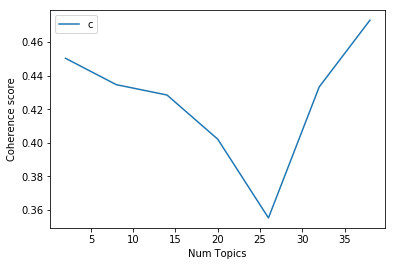

Num Topics = 2  has Coherence Value of 0.4503
Num Topics = 8  has Coherence Value of 0.4346
Num Topics = 14  has Coherence Value of 0.4285
Num Topics = 20  has Coherence Value of 0.4022
Num Topics = 26  has Coherence Value of 0.3553
Num Topics = 32  has Coherence Value of 0.4333
Num Topics = 38  has Coherence Value of 0.473


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=randomseed, chunksize=100, update_every=1, passes=10, per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

nr_topics = 1
coherence_max = 0

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    if cv > coherence_max:
        coherence_max = cv
        nr_topics = m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [19]:
def elbowPoint(points):
    secondDerivative = collections.defaultdict(lambda:0)
    for i in range(1, len(points) - 1):
        secondDerivative[i] = points[i+1] + points[i-1] - 2*points[i]

    max_index = list(secondDerivative.values()).index(max(secondDerivative.values()))
    elbow_point = max_index + 1
    return elbow_point

In [20]:
points_lda = coherence_values
max_point_lda = elbowPoint(points_lda)
print(max_point_lda)

4


In [21]:
# Build optimal LDA model

lda_optimal_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=max_point_lda, 
                                       random_state=randomseed,
                                       chunksize=100,
                                       update_every=1,
                                       passes=10,
                                       per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_optimal_model.print_topics())
doc_lda_optimal = lda_optimal_model[corpus]

[(0,
  '0.025*"docent" + 0.020*"student" + 0.018*"moeten" + 0.018*"goed" + '
  '0.017*"geven" + 0.015*"toets" + 0.015*"les" + 0.014*"vak" + 0.014*"maken" + '
  '0.014*"krijgen"'),
 (1,
  '0.042*"student" + 0.034*"jaar" + 0.034*"goed" + 0.034*"opleiding" + '
  '0.027*"stage" + 0.013*"begeleiding" + 0.011*"mogelijkheid" + '
  '0.010*"informatie" + 0.010*"communicatie" + 0.009*"maken"'),
 (2,
  '0.026*"werken" + 0.019*"praktijk" + 0.017*"ruimte" + 0.014*"groep" + '
  '0.013*"waar" + 0.012*"studeren" + 0.011*"college" + 0.011*"onderwijs" + '
  '0.011*"school" + 0.010*"kunnen"'),
 (3,
  '0.034*"erg" + 0.029*"docent" + 0.029*"vinden" + 0.019*"opleiding" + '
  '0.018*"goed" + 0.016*"dag" + 0.015*"uur" + 0.015*"heel" + 0.014*"module" + '
  '0.013*"les"')]


In [61]:
topic_probability_scores = lda_optimal_model.transform(data_lemmatized)
topic_probability_scores

AttributeError: 'LdaModel' object has no attribute 'transform'

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_optimal_model, corpus, id2word)
vis

C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.148037 -0.001036       1        1  33.621456
1     -0.117572 -0.246355       2        1  29.483181
3     -0.079285  0.269795       3        1  21.822491
2      0.344894 -0.022404       4        1  15.072876, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
106   Default  4534.000000          jaar  4534.000000  30.0000  30.0000
37    Default  3358.000000           erg  3358.000000  29.0000  29.0000
138   Default  8526.000000       student  8526.000000  28.0000  28.0000
24    Default  3575.000000         stage  3575.000000  27.0000  27.0000
46    Default  6370.000000     opleiding  6370.000000  26.0000  26.0000
63    Default  6642.000000        docent  6642.000000  25.0000  25.0000
49    Default  4656.000000        vinden  4656.000000  24.0000  24.0000
16    Default  2142.000000        werken  2142.000000  23.0000  23.0000
152   Default  2252.000000         toets  2252.000000  22.0000  22.0000
361   Default  1284.000000      praktijk  1284.000000  21.0000  21.0000
0     Default  1590.000000           dag  1590.000000  20.0000  20.0000
10    Default  1483.000000           uur  1483.000000  19.0000  19.0000
276   Default  1137.000000        ruimte  1137.000000  18.0000  18.0000
45    Default  1400.000000        module  1400.000000  17.0000  17.0000
303   Default  1717.000000   begeleiding  1717.000000  16.0000  16.0000
65    Default  3839.000000         geven  3839.000000  15.0000  15.0000
82    Default  2365.000000          heel  2365.000000  14.0000  14.0000
31    Default  1657.000000      opdracht  1657.000000  13.0000  13.0000
768   Default   922.000000         groep   922.000000  12.0000  12.0000
244   Default  1389.000000  mogelijkheid  1389.000000  11.0000  11.0000
160   Default  3539.000000        moeten  3539.000000  10.0000  10.0000
85    Default  3653.000000           les  3653.000000   9.0000   9.0000
44    Default  2452.000000       krijgen  2452.000000   8.0000   8.0000
30    Default  1456.000000         leren  1456.000000   7.0000   7.0000
62    Default  1298.000000  communicatie  1298.000000   6.0000   6.0000
59    Default  1415.000000         vraag  1415.000000   5.0000   5.0000
15    Default  2579.000000           wel  2579.000000   4.0000   4.0000
278   Default   782.000000      studeren   782.000000   3.0000   3.0000
97    Default  2247.000000          waar  2247.000000   2.0000   2.0000
494   Default  1351.000000          doen  1351.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
217    Topic4   461.639038          plek   462.414307   1.8906  -4.9852
534    Topic4   465.182861          boek   465.977264   1.8906  -4.9776
1186   Topic4   462.084167      leerjaar   462.886902   1.8905  -4.9843
1045   Topic4   401.930634   beschikbaar   402.728729   1.8903  -5.1237
107    Topic4   394.628296        rustig   395.416901   1.8903  -5.1421
9      Topic4   403.261566         thuis   404.072662   1.8903  -5.1204
38     Topic4   409.587280          even   410.427277   1.8902  -5.1049
599    Topic4   401.911499         bezig   402.766754   1.8901  -5.1238
951    Topic4   340.770721    verdieping   341.567474   1.8899  -5.2888
528    Topic4   312.750519  studieruimte   313.517242   1.8898  -5.3746
377    Topic4   309.723114    werkruimte   310.494720   1.8898  -5.3843
1011   Topic4   309.387421        aanbod   310.206573   1.8896  -5.3854
228    Topic4   302.163330         lezen   302.983826   1.8896  -5.4090
418    Topic4   313.875061    zelfstudie   314.734344   1.8895  -5.3710
120    Topic4   300.255768           oud   301.083954   1.8895  -5.4154
416    Topic4   285.395172      beperken   286.199432   1.8895  -5.4661
414    Topic4   345.852020      werkvorm   346.832642   1.8894  -5.2740
658    Topic4   411.498230       

In [24]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list               
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(15)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             3.0              0.4533   
1             1             1.0              0.5582   
2             2             3.0              0.6789   
3             3             3.0              0.5657   
4             4             3.0              0.6359   
5             5             1.0              0.4275   
6             6             1.0              0.4864   
7             7             1.0              0.5903   
8             8             2.0              0.4651   
9             9             0.0              0.3851   
10           10             0.0              0.7631   
11           11             0.0              0.5207   
12           12             0.0              0.5785   
13           13             1.0              0.5691   
14           14             1.0              0.4383   

                                             Keywords  \
0   erg, docent, vinden, opleiding, goed, dag, uur...   
1   student, jaar, goed, opleiding, stage, begelei...   
2   erg, docent, vinden, opleiding, goed, dag, uur...   
3   erg, docent, vinden, opleiding, goed, dag, uur...   
4   erg, docent, vinden, opleiding, goed, dag, uur...   
5   student, jaar, goed, opleiding, stage, begelei...   
6   student, jaar, goed, opleiding, stage, begelei...   
7   student, jaar, goed, opleiding, stage, begelei...   
8   werken, praktijk, ruimte, groep, waar, studere...   
9   docent, student, moeten, goed, geven, toets, l...   
10  docent, student, moeten, goed, geven, toets, l...   
11  docent, student, moeten, goed, geven, toets, l...   
12  docent, student, moeten, goed, geven, toets, l...   
13  student, jaar, goed, opleiding, stage, begelei...   
14  student, jaar, goed, opleiding, stage, begelei...   

                                                 Text  
0   [lesrooster, vorig, periode, goed, hebben, wee...  
1   [maken, duidelijk, link, stage, vak, school, m...  
2   [groot, opdracht, groot, reistijd, contact, uu...  
3   [kiezen, module, even, interessant, overlappen...  
4    [snel, reageren, vraag, examencommissie, sturen]  
5   [onderling, communicatie, docent, vak, geven, ...  
6   [graag, zien, cmv, hoog, niveau, krijgen, echt...  
7   [fijn, vinden, aanbieden, stof, verspreiden, a...  
8   [houden, rekening, ervaring, oud, leerling, bu...  
9   [stage, vinden, erg, slecht, aansluit, school,...  
10  [discrepantie, aanbieden, lesstof, oefentoets,...  
11  [duidelijkheid, student, docent, afspreken, ho...  
12  [belangrijk, informatie, snel, doorgeven, betr...  
13  [leraar, elders, halen, extern, zorg, fonty, g...  
14  [restaurant, leveren, laag, kwaliteit, hoog, p...

In [25]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.9581   
1         0.0              0.9573   
2         0.0              0.9556   
3         0.0              0.9544   
4         0.0              0.9519   
5         1.0              0.9570   
6         1.0              0.9457   
7         1.0              0.9456   
8         1.0              0.9425   
9         1.0              0.9419   
10        2.0              0.9520   
11        2.0              0.9461   
12        2.0              0.9454   
13        2.0              0.9451   
14        2.0              0.9421   
15        3.0              0.9518   
16        3.0              0.9461   
17        3.0              0.9406   
18        3.0              0.9386   
19        3.0              0.9364   

                                                                                             Keywords  \
0                               docent, student, moeten, goed, geven, toets, les, vak, maken, krijgen   
1                               docent, student, moeten, goed, geven, toets, les, vak, maken, krijgen   
2                               docent, student, moeten, goed, geven, toets, les, vak, maken, krijgen   
3                               docent, student, moeten, goed, geven, toets, les, vak, maken, krijgen   
4                               docent, student, moeten, goed, geven, toets, les, vak, maken, krijgen   
5   student, jaar, goed, opleiding, stage, begeleiding, mogelijkheid, informatie, communicatie, maken   
6   student, jaar, goed, opleiding, stage, begeleiding, mogelijkheid, informatie, communicatie, maken   
7   student, jaar, goed, opleiding, stage, begeleiding, mogelijkheid, informatie, communicatie, maken   
8   student, jaar, goed, opleiding, stage, begeleiding, mogelijkheid, informatie, communicatie, maken   
9   student, jaar, goed, opleiding, stage, begeleiding, mogelijkheid, informatie, communicatie, maken   
10                werken, praktijk, ruimte, groep, waar, studeren, college, onderwijs, school, kunnen   
11                werken, praktijk, ruimte, groep, waar, studeren, college, onderwijs, school, kunnen   
12                werken, praktijk, ruimte, groep, waar, studeren, college, onderwijs, school, kunnen   
13                werken, praktijk, ruimte, groep, waar, studeren, college, onderwijs, school, kunnen   
14                werken, praktijk, ruimte, groep, waar, studeren, college, onderwijs, school, kunnen   
15                                  erg, docent, vinden, opleiding, goed, dag, uur, heel, module, les   
16                                  erg, docent, vinden, opleiding, goed, dag, uur, heel, module, les   
17                                  erg, docent, vinden, opleiding, goed, dag, uur, heel, module, les   
18                                  erg, docent, vinden, opleiding, goed, dag, uur, heel, module, les   
19                                  erg, docent, vinden, opleiding, goed, dag, uur, heel, module, les   

                                                                                    Representative Text  
0   [docent, weten, helemaal, dyslexie, weten, mee, moeten, voordeel, moeten, geven, spelfout, krijg...  
1   [proberen, soms, delen, klas, apart, houden, gaan, stof, student, nooit, hebben, bijvoorbeeld, s...  
2   [reactie, email, duren, docent, lang, geval, krijgen, terug, nakijk, duren, lang, pas, week, laa...  
3   [docent, gehoor, vaak, onduidelijk, uitleg, vaak, weten, antwoord, vraag, daardoor, moeilijk, le...  
4   [docent, geven, nauwelijks, antwoord, vraag, stellen, via_email, tentamens, fijn, student, duide...  
5   [begin, blok, goed, overzicht, geven, nieuw, vak, goed, introducer, student, vooral, jaar, weten...  
6   [rooster, tijdig, bekend, maken, informatie, stage, profilering, duidelijk, communicer, vooral, ...  
7   [informatie, geven, jaar, eruit, gaan, zien, informatie, profilering, informatie, stage, eventue...  
8   [goed, informatie, start, opleiding, tussenliggend, blok, jaar

## Building LDA Mallet Model

Mallet’s version should give a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself.

In [26]:
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet.bat' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('stage', 0.08332762908709243),
   ('begeleiding', 0.0402947954457298),
   ('goed', 0.039587468911857986),
   ('minor', 0.028156159445090926),
   ('mogelijkheid', 0.027585734821000754),
   ('willen', 0.025783193008875806),
   ('graag', 0.022383462249298377),
   ('lopen', 0.021447965865790494),
   ('school', 0.020672188377027858),
   ('zien', 0.02028429963264654)]),
 (1,
  [('wel', 0.053153611393692776),
   ('vinden', 0.04249321804001356),
   ('gaan', 0.04088250254323499),
   ('krijgen', 0.03397338080705324),
   ('hebben', 0.03346473380807053),
   ('doen', 0.03020091556459817),
   ('weten', 0.025241607324516784),
   ('echt', 0.025029671074940658),
   ('mee', 0.023906408952187184),
   ('mens', 0.01818413021363174)]),
 (2,
  [('maken', 0.06384963706282568),
   ('duidelijk', 0.04539559014267185),
   ('informatie', 0.03649850956834369),
   ('periode', 0.03529251143422759),
   ('rooster', 0.02989965185336883),
   ('eerder', 0.02751041026691242),
   ('week', 0.025212187407559105),
   

In [27]:
pyLDAvis.enable_notebook()
mallet_pyldavis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
vis_mallet = pyLDAvis.gensim.prepare(mallet_pyldavis, corpus, id2word)
vis_mallet

C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.234000 -0.020187       1        1  10.540783
4      0.188503 -0.120996       2        1  10.146866
3      0.178526  0.239124       3        1  10.113191
9     -0.008477 -0.194967       4        1   9.986420
5     -0.221638 -0.117621       5        1   9.967050
7     -0.085788  0.234754       6        1   9.964444
6     -0.167452  0.160145       7        1   9.917235
0     -0.061346  0.082085       8        1   9.894825
2     -0.213607 -0.135814       9        1   9.738651
8      0.157279 -0.126523      10        1   9.730534, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
138   Default  9342.000000       student  9342.000000  30.0000  30.0000
63    Default  6990.000000        docent  6990.000000  29.0000  29.0000
46    Default  6435.000000     opleiding  6435.000000  28.0000  28.0000
106   Default  4727.000000          jaar  4727.000000  27.0000  27.0000
1     Default  9668.000000          goed  9668.000000  26.0000  26.0000
24    Default  3692.000000         stage  3692.000000  25.0000  25.0000
85    Default  3667.000000           les  3667.000000  24.0000  24.0000
25    Default  3432.000000           vak  3432.000000  23.0000  23.0000
37    Default  3415.000000           erg  3415.000000  22.0000  22.0000
49    Default  4652.000000        vinden  4652.000000  21.0000  21.0000
20    Default  3883.000000         maken  3883.000000  20.0000  20.0000
160   Default  3727.000000        moeten  3727.000000  19.0000  19.0000
152   Default  2327.000000         toets  2327.000000  18.0000  18.0000
15    Default  2833.000000           wel  2833.000000  17.0000  17.0000
65    Default  3698.000000         geven  3698.000000  16.0000  16.0000
16    Default  2053.000000        werken  2053.000000  15.0000  15.0000
163   Default  2825.000000          vaak  2825.000000  14.0000  14.0000
17    Default  1992.000000     duidelijk  1992.000000  13.0000  13.0000
43    Default  2948.000000         komen  2948.000000  12.0000  12.0000
82    Default  2501.000000          heel  2501.000000  11.0000  11.0000
339   Default  3181.000000          gaan  3181.000000  10.0000  10.0000
303   Default  1786.000000   begeleiding  1786.000000   9.0000   9.0000
44    Default  2577.000000       krijgen  2577.000000   8.0000   8.0000
122   Default  2045.000000        zitten  2045.000000   7.0000   7.0000
33    Default  2411.000000          tijd  2411.000000   6.0000   6.0000
23    Default  2293.000000        school  2293.000000   5.0000   5.0000
97    Default  2255.000000          waar  2255.000000   4.0000   4.0000
31    Default  1630.000000      opdracht  1630.000000   3.0000   3.0000
173   Default  1958.000000    informatie  1958.000000   2.0000   2.0000
6     Default  1539.000000       periode  1539.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
193   Topic10   481.479433       kantine   481.479433   2.3299  -4.5055
272   Topic10   457.702671          open   457.702671   2.3299  -4.5562
658   Topic10   413.121242           vol   413.121242   2.3299  -4.6586
107   Topic10   354.670035        rustig   354.670035   2.3299  -4.8112
270   Topic10   353.679337        gebouw   353.679337   2.3299  -4.8140
816   Topic10   342.781654      aanwezig   342.781654   2.3299  -4.8453
528   Topic10   341.790956  studieruimte   341.790956   2.3299  -4.8482
277   Topic10   314.051400   stopcontact   314.051400   2.3299  -4.9328
377   Topic10   298.200225    werkruimte   298.200225   2.3299  -4.9846
1330  Topic10   297.209527       betalen   297.209527   2.3299  -4.9879
538   Topic10   294.237431    mediatheek   294.237431   2.3299  -4.9980
2145  Topic10   240.739717          geld   240.739717   2.3299  -5.1987
367   Topic10   225.879240          duur   225.879240   2.3299  -5.26

### Finding optimal number of topics for Mallet LDA

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

100%|███████████████████████████████████████████| 9/9 [15:33<00:00, 103.67s/it]


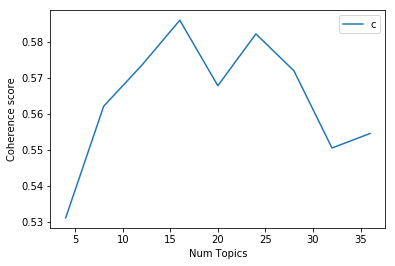

Num Topics = 4  has Coherence Value of 0.5311
Num Topics = 8  has Coherence Value of 0.5621
Num Topics = 12  has Coherence Value of 0.5735
Num Topics = 16  has Coherence Value of 0.586
Num Topics = 20  has Coherence Value of 0.5678
Num Topics = 24  has Coherence Value of 0.5822
Num Topics = 28  has Coherence Value of 0.5719
Num Topics = 32  has Coherence Value of 0.5505
Num Topics = 36  has Coherence Value of 0.5545


In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)
# Show graph
limit=40; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

nr_topics = 1
coherence_max = 0

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    if cv > coherence_max:
        coherence_max = cv
        nr_topics = m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [29]:
points = coherence_values
max_point = elbowPoint(points)
print(max_point)

4


In [30]:
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet.bat' # update this path
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=max_point, id2word=id2word)

# Show Topics
pprint(optimal_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_optimal = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet_optimal = coherence_model_ldamallet_optimal.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_optimal)

[(0,
  [('erg', 0.030840631106607803),
   ('vinden', 0.026869074328725484),
   ('vaak', 0.025430628935369473),
   ('heel', 0.02259897228052399),
   ('school', 0.020771513353115726),
   ('waar', 0.020527249041036404),
   ('werken', 0.018754071071867988),
   ('zitten', 0.0186545559817616),
   ('les', 0.017731779691684157),
   ('fijn', 0.014384453933560108)]),
 (1,
  [('jaar', 0.042476012169435994),
   ('stage', 0.03287187888170804),
   ('moeten', 0.031395704693153795),
   ('maken', 0.029001422167815802),
   ('toets', 0.02084645988226611),
   ('krijgen', 0.020252389781994274),
   ('tijd', 0.016255918198347406),
   ('komen', 0.016138904390718106),
   ('week', 0.015688851284451567),
   ('mogen', 0.014509712146033232)]),
 (2,
  [('student', 0.08260088074054103),
   ('goed', 0.07301159342140738),
   ('docent', 0.06298193583176058),
   ('geven', 0.03275815583715287),
   ('duidelijk', 0.018037206794284173),
   ('begeleiding', 0.015880291183607443),
   ('communicatie', 0.012357329019502112),
   

In [31]:
pyLDAvis.enable_notebook()
mallet_pyldavis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis_malletoptimal = pyLDAvis.gensim.prepare(mallet_pyldavis, corpus, id2word)
vis_malletoptimal

C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.212101  0.323120       1        1  25.372267
1      0.130375 -0.173415       2        1  25.007224
0     -0.251200 -0.241358       3        1  24.815186
2      0.332927  0.091653       4        1  24.805323, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
138   Default  9193.000000        student  9193.000000  30.0000  30.0000
63    Default  6998.000000         docent  6998.000000  29.0000  29.0000
1     Default  9641.000000           goed  9641.000000  28.0000  28.0000
46    Default  6425.000000      opleiding  6425.000000  27.0000  27.0000
106   Default  4757.000000           jaar  4757.000000  26.0000  26.0000
24    Default  3681.000000          stage  3681.000000  25.0000  25.0000
65    Default  3658.000000          geven  3658.000000  24.0000  24.0000
37    Default  3427.000000            erg  3427.000000  23.0000  23.0000
25    Default  3425.000000            vak  3425.000000  22.0000  22.0000
160   Default  3691.000000         moeten  3691.000000  21.0000  21.0000
163   Default  2826.000000           vaak  2826.000000  20.0000  20.0000
20    Default  3918.000000          maken  3918.000000  19.0000  19.0000
82    Default  2511.000000           heel  2511.000000  18.0000  18.0000
152   Default  2334.000000          toets  2334.000000  17.0000  17.0000
23    Default  2308.000000         school  2308.000000  16.0000  16.0000
97    Default  2281.000000           waar  2281.000000  15.0000  15.0000
16    Default  2084.000000         werken  2084.000000  14.0000  14.0000
122   Default  2073.000000         zitten  2073.000000  13.0000  13.0000
17    Default  2003.000000      duidelijk  2003.000000  12.0000  12.0000
44    Default  2577.000000        krijgen  2577.000000  11.0000  11.0000
85    Default  3613.000000            les  3613.000000  10.0000  10.0000
303   Default  1764.000000    begeleiding  1764.000000   9.0000   9.0000
14    Default  1757.000000           week  1757.000000   8.0000   8.0000
49    Default  4671.000000         vinden  4671.000000   7.0000   7.0000
31    Default  1620.000000       opdracht  1620.000000   6.0000   6.0000
105   Default  1599.000000           fijn  1599.000000   5.0000   5.0000
2     Default  1591.000000         hebben  1591.000000   4.0000   4.0000
6     Default  1563.000000        periode  1563.000000   3.0000   3.0000
30    Default  1540.000000          leren  1540.000000   2.0000   2.0000
33    Default  2398.000000           tijd  2398.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
194    Topic4   797.760140      kwaliteit   797.760140   1.3941  -4.9364
89     Topic4   764.811348         niveau   764.811348   1.3941  -4.9785
27     Topic4   755.825314        contact   755.825314   1.3941  -4.9904
181    Topic4   752.829969          fonty   752.829969   1.3941  -4.9943
61     Topic4   630.020836    beoordeling   630.020836   1.3941  -5.1724
166    Topic4   604.061182         zeggen   604.061182   1.3941  -5.2145
427    Topic4   553.140322          nemen   553.140322   1.3941  -5.3026
170    Topic4   546.151185      betreffen   546.151185   1.3941  -5.3153
69     Topic4   531.174461     verbeteren   531.174461   1.3941  -5.3431
310    Topic4   515.199289       verschil   515.199289   1.3941  -5.3736
589    Topic4   455.292395        stellen   455.292395   1.3941  -5.4972
232    Topic4   429.332741    verschillen   429.332741   1.3941  -5.5559
295    Topic4   427.335845       proberen   427.335845   1.3941  -5.5606
753    Topic4   420.346707         vragen   420.346707   1.3941  -5.5771
350    Topic4   402.374639      studenten   402.374639   1.3941  -5.6208
810    Topic4   396.383949       antwoord   396.383949   1.3941  -5.6358
334    Topic4   385.401019           zaak   385.401019  

### Most representative sentences

In [50]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    texts_resetindex = documents['Opmerking'].reset_index(drop=True)
    contents = pd.Series(texts_resetindex)
    print("---Contents 1---")
    print(contents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents['Opmerking'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

---Contents 1---
0        het lesrooster was de vorige perioden veel beter toen hadden we elke week wel een dag vrij waard...
1        maak een duidelijkere link tussen de stage en de vakken op school op het moment dat je stage loo...
2        door de te grote opdrachten en de grote reistijd en de vele contact uren op school heb je bijna ...
3        de gekozen modules zijn niet voor iedereen even interessant en overlappen elkaar soms dit is zon...
4                                        sneller reageren op vragen die naar examencommissie gestuurd worden
5        de onderlinge communicatie tussen de docenten die hetzelfde vak geven of hetzelfde beoordelen mo...
6        ik zou graag zien dat cmv een hoger niveau krijgt dus echt wat je verwacht bij een hboopleiding ...
7        ik zou het fijn vinden als de aangeboden stof meer verspreid wordt aangebonden tijdens de 4 jaar...
8        men houd te weinig rekening met ervaringen van  oudere leerlingen die een bult ervaring met zich...
9 

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.3031   
1            1             1.0              0.2917   
2            2             0.0              0.3095   
3            3             3.0              0.3326   
4            4             2.0              0.2818   
5            5             2.0              0.3655   
6            6             3.0              0.4151   
7            7             1.0              0.2919   
8            8             0.0              0.2688   
9            9             3.0              0.3189   

                                                                                      Keywords  \
0                             erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
1                         jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
2                             erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
3                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
4  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
5  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
6                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
7                         jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
8                             erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
9                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   

                                                                                                  Text  
0  het lesrooster was de vorige perioden veel beter toen hadden we elke week wel een dag vrij waard...  
1  maak een duidelijkere link tussen de stage en de vakken op school op het moment dat je stage loo...  
2  door de te grote opdrachten en de grote reistijd en de vele contact uren op school heb je bijna ...  
3  de gekozen modules zijn niet voor iedereen even interessant en overlappen elkaar soms dit is zon...  
4                                  sneller reageren op vragen die naar examencommissie gestuurd worden  
5  de onderlinge communicatie tussen de docenten die hetzelfde vak geven of hetzelfde beoordelen mo...  
6  ik zou graag zien dat cmv een hoger niveau krijgt dus echt wat je verwacht bij een hboopleiding ...  
7  ik zou het fijn vinden als de aangeboden stof meer verspreid wordt aangebonden tijdens de 4 jaar...  
8  men houd te weinig rekening met ervaringen van  oudere leerlingen die een bult ervaring met zich...  
9  de stages vind ik erg slecht aansluiten op wat er op school geleerd word we word opgeleid om mul...

In [53]:
df_topic_sents_keywords

Dominant_Topic  Perc_Contribution  \
0                 0.0             0.3031   
1                 1.0             0.2917   
2                 0.0             0.3095   
3                 3.0             0.3326   
4                 2.0             0.2818   
5                 2.0             0.3655   
6                 3.0             0.4151   
7                 1.0             0.2919   
8                 0.0             0.2688   
9                 3.0             0.3189   
10                3.0             0.3039   
11                2.0             0.3325   
12                2.0             0.2750   
13                2.0             0.3153   
14                0.0             0.3179   
15                1.0             0.3291   
16                2.0             0.3141   
17                0.0             0.2856   
18                3.0             0.3341   
19                1.0             0.2797   
20                1.0             0.3326   
21                3.0             0.3059   
22                0.0             0.3929   
23                3.0             0.2941   
24                2.0             0.3413   
25                0.0             0.2544   
26                2.0             0.2863   
27                2.0             0.3360   
28                2.0             0.3361   
29                0.0             0.2949   
...               ...                ...   
27587             1.0             0.2942   
27588             3.0             0.2905   
27589             3.0             0.2823   
27590             3.0             0.3475   
27591             0.0             0.2870   
27592             3.0             0.3235   
27593             2.0             0.2943   
27594             2.0             0.2750   
27595             0.0             0.2769   
27596             2.0             0.3031   
27597             2.0             0.2739   
27598             3.0             0.3094   
27599             2.0             0.2797   
27600             1.0             0.2866   
27601             0.0             0.2846   
27602             3.0             0.3364   
27603             1.0             0.3127   
27604             0.0             0.3136   
27605             1.0             0.3324   
27606             1.0             0.2589   
27607             3.0             0.2961   
27608             0.0             0.2778   
27609             2.0             0.2748   
27610             0.0             0.2870   
27611             2.0             0.3093   
27612             1.0             0.2993   
27613             3.0             0.2966   
27614             3.0             0.3325   
27615             3.0             0.3116   
27616             3.0             0.2736   

                                                                                    Topic_Keywords  \
0                                 erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
1                             jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
2                                 erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
3                            opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
4      student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
5      student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
6                            opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
7                             jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
8                                 erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
9                            opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
10                           opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
11     student, goed, docent, geven, duidelijk, begele

In [51]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.5118   
1         0.0              0.5028   
2         0.0              0.4995   
3         0.0              0.4969   
4         0.0              0.4922   
5         1.0              0.4854   
6         1.0              0.4744   
7         1.0              0.4511   
8         1.0              0.4500   
9         1.0              0.4496   
10        2.0              0.4890   
11        2.0              0.4750   
12        2.0              0.4612   
13        2.0              0.4518   
14        2.0              0.4459   
15        3.0              0.5283   
16        3.0              0.5057   
17        3.0              0.4990   
18        3.0              0.4872   
19        3.0              0.4793   

                                                                                       Keywords  \
0                              erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
1                              erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
2                              erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
3                              erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
4                              erg, vinden, vaak, heel, school, waar, werken, zitten, les, fijn   
5                          jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
6                          jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
7                          jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
8                          jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
9                          jaar, stage, moeten, maken, toets, krijgen, tijd, komen, week, mogen   
10  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
11  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
12  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
13  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
14  student, goed, docent, geven, duidelijk, begeleiding, communicatie, leerling, leraar, vraag   
15                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
16                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
17                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
18                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   
19                        opleiding, vak, gaan, les, leren, praktijk, alleen, zien, willen, wel   

                                                                                                   Text  
0   ik vind dat er geen fijne plek in de school is om rustig te werken de meeste werkplekken zitten ...  
1   na de verbouwing van het studielandschap afgelopen jaar zit het studielandschap altijd helemaal ...  
2   de kantine is veels te duur dit moet echt goedkoper de prijs aan wat je voor een stuk fruit koop...  
3   ik vind dat er in het gebouw nog steeds te weinig echte leerplekken zijn in de aula leren is nie...  
4   ik zou het erg fijn vinden om een studieruimte te hebben waar je na of voor schooltijd lekker aa...  
5   de cijfers mogen wel wat eerder bekend gemaakt wordendus niet 3 weken wachten op een cijfer voor...  
6   we hebben aan het eind van een blok één tentamen over 4 vakken kerna kernb kernc en afp het lijk...  
7   ik vind het een beetje gek dat we vanaf het begin moeten stage lopen terwijl we nog helemaal nie...  
8   ik ben van mening dat er verbetering kan worden gesteld ten aanzien van de kansen dat een tentam...  
9   zorg aub voor betere communicatie betreft stageplekken maar geef ook exacte period